In [1]:
import tensorflow as tf 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import tensorflow.keras as keras
import util
import pandas as pd
import seaborn as sns
import numpy as np
from tensorflow.keras import layers
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics  import accuracy_score
import math
from sklearn.decomposition import PCA

tf.config.experimental_run_functions_eagerly(True)


# Cargamos los datos

Obtenemos los nombres de las imágenes y sus etiquetas

In [2]:
ALL_DATA = "E:Corrected_FA/ALL_DATA/"
info_data = "idaSearch_8_01_2020.csv"

# Obtenemos los diccionarios con los nombres de los ficheros que contienen las imágenes
AD_CN, groups = util.obtain_data_files(ALL_DATA, info_data)

imgs = []
labels = []
for key in AD_CN.keys():
    for img in AD_CN[key]:
        imgs.append(img) 
        labels.append(key)

image_labels = pd.DataFrame({"Image": imgs, "Label": labels} )
image_labels.head()

,Image,Label
0,ADNI_003_S_4081_MR_corrected_FA_image_Br_20120...,CN
1,ADNI_003_S_4081_MR_corrected_FA_image_Br_20131...,CN
2,ADNI_003_S_4119_MR_corrected_FA_image_Br_20120...,CN
3,ADNI_003_S_4119_MR_corrected_FA_image_Br_20120...,CN
4,ADNI_003_S_4119_MR_corrected_FA_image_Br_20130...,CN


Cargamos el dataset de imágenes

In [3]:
fpcas_temporal_right = pd.read_csv("FPCAs/FPCAS_Ventricle.csv", index_col = 0)
images_size = fpcas_temporal_right.shape[1]-1

Unimos imágenes con etiquetas

In [4]:
df_temporal_right = fpcas_temporal_right.merge(image_labels, left_on = "file", right_on = "Image")
data = df_temporal_right.copy()
data["SubjectID"] = data["file"].apply(lambda x: x[5:15])
data = data.drop(["file", "Image"], axis=1)
data

,FPC_1,FPC_2,FPC_3,FPC_4,FPC_5,FPC_6,FPC_7,FPC_8,FPC_9,FPC_10,...,FPC_40,FPC_41,FPC_42,FPC_43,FPC_44,FPC_45,FPC_46,FPC_47,Label,SubjectID
0,1.426598,0.112181,-0.322595,-0.033974,0.137037,-0.154825,0.014088,-0.041808,0.032636,-0.120359,...,-0.115859,0.002507,-0.071014,0.003743,-0.071799,-0.013446,0.023629,-0.033078,CN,003_S_4081
1,1.447385,0.120397,-0.326797,-0.004794,0.071308,-0.121966,0.084857,-0.073673,0.041247,-0.115501,...,-0.087622,-0.001160,-0.033449,-0.000071,-0.028571,-0.012131,0.011141,-0.051622,CN,003_S_4081
2,1.671375,0.115622,0.097130,0.073061,-0.007771,0.018225,0.117936,0.046433,0.031110,0.035902,...,0.042103,0.023665,-0.045756,-0.038222,-0.026490,0.016583,0.026718,0.021704,CN,003_S_4119
3,1.635482,0.068551,0.149279,0.064166,-0.014603,0.046951,0.025481,0.036126,0.058780,-0.003189,...,0.051569,-0.000363,-0.070958,-0.026215,-0.062745,0.015311,0.015830,0.027684,CN,003_S_4119
4,1.531853,-0.371275,0.160936,-0.147053,0.181173,0.045500,0.081013,-0.113544,0.143626,0.046215,...,0.086668,-0.004663,-0.079088,-0.082042,-0.019592,0.076686,0.003082,0.001188,CN,003_S_4119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,1.512948,-0.373168,0.136220,-0.007119,-0.110302,-0.001779,-0.073120,-0.008893,0.068726,-0.120261,...,-0.079238,-0.099450,-0.002123,-0.015750,0.043629,-0.051654,-0.040108,0.055429,CN,129_S_4422
366,1.537276,0.165208,0.091943,-0.045060,-0.034294,0.063803,-0.100678,0.043170,-0.031374,0.052864,...,0.006285,-0.052607,-0.026298,0.014952,0.046099,-0.042051,-0.056600,0.107450,CN,129_S_4422
367,1.403889,0.080721,-0.193643,0.015488,-0.048856,0.132803,0.133546,0.035902,0.068759,0.169236,...,-0.029963,-0.062132,-0.039073,-0.053222,0.018678,0.022814,-0.050268,0.074394,CN,131_S_0123
368,1.549337,0.191282,0.039588,0.054031,0.033168,0.025229,0.044374,0.039591,0.041182,0.032756,...,-0.025476,0.002272,0.013597,-0.050911,0.034598,0.041045,-0.016493,0.003273,CN,131_S_0123


In [5]:
fpcas_temporal_right

,FPC_1,FPC_2,FPC_3,FPC_4,FPC_5,FPC_6,FPC_7,FPC_8,FPC_9,FPC_10,...,FPC_39,FPC_40,FPC_41,FPC_42,FPC_43,FPC_44,FPC_45,FPC_46,FPC_47,file
1,1.426598,0.112181,-0.322595,-0.033974,0.137037,-0.154825,0.014088,-0.041808,0.032636,-0.120359,...,0.078227,-0.115859,0.002507,-0.071014,0.003743,-0.071799,-0.013446,0.023629,-0.033078,ADNI_003_S_4081_MR_corrected_FA_image_Br_20120...
2,1.447385,0.120397,-0.326797,-0.004794,0.071308,-0.121966,0.084857,-0.073673,0.041247,-0.115501,...,0.038899,-0.087622,-0.001160,-0.033449,-0.000071,-0.028571,-0.012131,0.011141,-0.051622,ADNI_003_S_4081_MR_corrected_FA_image_Br_20131...
3,1.671375,0.115622,0.097130,0.073061,-0.007771,0.018225,0.117936,0.046433,0.031110,0.035902,...,-0.004013,0.042103,0.023665,-0.045756,-0.038222,-0.026490,0.016583,0.026718,0.021704,ADNI_003_S_4119_MR_corrected_FA_image_Br_20120...
4,1.635482,0.068551,0.149279,0.064166,-0.014603,0.046951,0.025481,0.036126,0.058780,-0.003189,...,-0.005380,0.051569,-0.000363,-0.070958,-0.026215,-0.062745,0.015311,0.015830,0.027684,ADNI_003_S_4119_MR_corrected_FA_image_Br_20120...
5,1.531853,-0.371275,0.160936,-0.147053,0.181173,0.045500,0.081013,-0.113544,0.143626,0.046215,...,-0.017159,0.086668,-0.004663,-0.079088,-0.082042,-0.019592,0.076686,0.003082,0.001188,ADNI_003_S_4119_MR_corrected_FA_image_Br_20130...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,1.512948,-0.373168,0.136220,-0.007119,-0.110302,-0.001779,-0.073120,-0.008893,0.068726,-0.120261,...,0.026748,-0.079238,-0.099450,-0.002123,-0.015750,0.043629,-0.051654,-0.040108,0.055429,ADNI_129_S_4422_MR_corrected_FA_image_Br_20140...
367,1.537276,0.165208,0.091943,-0.045060,-0.034294,0.063803,-0.100678,0.043170,-0.031374,0.052864,...,0.074753,0.006285,-0.052607,-0.026298,0.014952,0.046099,-0.042051,-0.056600,0.107450,ADNI_129_S_4422_MR_corrected_FA_image_Br_20160...
368,1.403889,0.080721,-0.193643,0.015488,-0.048856,0.132803,0.133546,0.035902,0.068759,0.169236,...,-0.009194,-0.029963,-0.062132,-0.039073,-0.053222,0.018678,0.022814,-0.050268,0.074394,ADNI_131_S_0123_MR_corrected_FA_image_Br_20130...
369,1.549337,0.191282,0.039588,0.054031,0.033168,0.025229,0.044374,0.039591,0.041182,0.032756,...,-0.054471,-0.025476,0.002272,0.013597,-0.050911,0.034598,0.041045,-0.016493,0.003273,ADNI_131_S_0123_MR_corrected_FA_image_Br_20140...


## Cargamos los datos genéticos

In [6]:
df_APP = pd.read_csv("GenesRAW/APP.raw", sep= " ").drop(["FID", "PHENOTYPE"], axis = 1)
df_gen = df_APP.copy()
df_gen = df_gen.fillna(-1)

In [7]:
X = df_gen.values[:,1:]
subjects = df_gen.values[:,0].reshape(-1,1)
pca = PCA(n_components = 50, svd_solver="full")
pca.fit(X.T)
pca_components = pca.components_.T
genetic_data = pd.DataFrame(np.concatenate((subjects, pca_components), axis = 1))
pca_components_size = pca_components.shape[1]

In [8]:
data = genetic_data.merge(data, how = "inner", left_on=genetic_data[0] , right_on= data["SubjectID"]) 
data = data.drop(["Label", 0, "key_0", "SubjectID"], axis = 1)
data

,1,2,3,4,5,6,7,8,9,10,...,FPC_38,FPC_39,FPC_40,FPC_41,FPC_42,FPC_43,FPC_44,FPC_45,FPC_46,FPC_47
0,0.0315417,0.00361028,0.173645,-0.0188015,0.0197203,0.0700165,-0.138493,0.0504229,-0.00143835,-0.0559838,...,0.018160,-0.022355,-0.036340,-0.027112,-0.010663,0.044194,0.046396,-0.030657,-0.018097,-0.015073
1,0.0315417,0.00361028,0.173645,-0.0188015,0.0197203,0.0700165,-0.138493,0.0504229,-0.00143835,-0.0559838,...,-0.024233,0.049464,-0.045326,-0.082888,-0.044900,0.047117,0.036138,-0.066257,-0.046064,0.044388
2,0.0315417,0.00361028,0.173645,-0.0188015,0.0197203,0.0700165,-0.138493,0.0504229,-0.00143835,-0.0559838,...,-0.023628,0.023400,-0.028083,-0.031774,-0.019188,0.025898,0.031003,-0.038402,-0.050941,0.027331
3,0.145224,-0.118472,-0.0237019,-0.150289,-0.0895208,-0.0122501,0.0449984,0.026083,-0.0853706,-0.0325273,...,0.009331,-0.041951,0.045545,-0.025293,0.037469,-0.049422,-0.007583,0.065837,-0.019984,-0.000491
4,0.145224,-0.118472,-0.0237019,-0.150289,-0.0895208,-0.0122501,0.0449984,0.026083,-0.0853706,-0.0325273,...,0.011163,-0.010774,0.047061,0.012251,0.034366,-0.070243,-0.031386,0.055891,-0.052672,-0.011275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,0.139964,-0.125224,-0.000453186,-0.155183,-0.0981822,-0.0566899,-0.0804735,-0.0608238,-0.119845,-0.163065,...,0.008383,0.021989,-0.023682,-0.090954,0.029399,-0.002256,0.013506,0.007864,-0.021711,-0.012674
264,0.139964,-0.125224,-0.000453186,-0.155183,-0.0981822,-0.0566899,-0.0804735,-0.0608238,-0.119845,-0.163065,...,-0.008181,0.021733,-0.037882,-0.055654,-0.032696,-0.026299,0.023417,0.005193,-0.022022,0.021283
265,0.139964,-0.125224,-0.000453186,-0.155183,-0.0981822,-0.0566899,-0.0804735,-0.0608238,-0.119845,-0.163065,...,-0.019045,0.047250,0.022030,-0.101278,0.025171,0.011467,0.025422,0.052595,0.039953,-0.021489
266,0.139964,-0.125224,-0.000453186,-0.155183,-0.0981822,-0.0566899,-0.0804735,-0.0608238,-0.119845,-0.163065,...,-0.004283,-0.021437,-0.034504,-0.029066,0.032781,-0.035008,0.009671,0.029233,0.001915,-0.015616


In [9]:
data = data.astype("float32")
data

,1,2,3,4,5,6,7,8,9,10,...,FPC_38,FPC_39,FPC_40,FPC_41,FPC_42,FPC_43,FPC_44,FPC_45,FPC_46,FPC_47
0,0.031542,0.003610,0.173645,-0.018801,0.019720,0.070017,-0.138493,0.050423,-0.001438,-0.055984,...,0.018160,-0.022355,-0.036340,-0.027112,-0.010663,0.044194,0.046396,-0.030657,-0.018097,-0.015073
1,0.031542,0.003610,0.173645,-0.018801,0.019720,0.070017,-0.138493,0.050423,-0.001438,-0.055984,...,-0.024233,0.049464,-0.045326,-0.082888,-0.044900,0.047117,0.036138,-0.066257,-0.046064,0.044388
2,0.031542,0.003610,0.173645,-0.018801,0.019720,0.070017,-0.138493,0.050423,-0.001438,-0.055984,...,-0.023628,0.023400,-0.028083,-0.031774,-0.019188,0.025898,0.031003,-0.038402,-0.050941,0.027331
3,0.145224,-0.118472,-0.023702,-0.150289,-0.089521,-0.012250,0.044998,0.026083,-0.085371,-0.032527,...,0.009331,-0.041951,0.045545,-0.025293,0.037469,-0.049422,-0.007583,0.065837,-0.019984,-0.000491
4,0.145224,-0.118472,-0.023702,-0.150289,-0.089521,-0.012250,0.044998,0.026083,-0.085371,-0.032527,...,0.011163,-0.010774,0.047061,0.012251,0.034366,-0.070243,-0.031386,0.055891,-0.052672,-0.011275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,0.139964,-0.125224,-0.000453,-0.155183,-0.098182,-0.056690,-0.080473,-0.060824,-0.119845,-0.163065,...,0.008383,0.021989,-0.023682,-0.090954,0.029399,-0.002256,0.013506,0.007864,-0.021711,-0.012674
264,0.139964,-0.125224,-0.000453,-0.155183,-0.098182,-0.056690,-0.080473,-0.060824,-0.119845,-0.163065,...,-0.008181,0.021733,-0.037882,-0.055654,-0.032696,-0.026299,0.023417,0.005193,-0.022022,0.021283
265,0.139964,-0.125224,-0.000453,-0.155183,-0.098182,-0.056690,-0.080473,-0.060824,-0.119845,-0.163065,...,-0.019045,0.047250,0.022030,-0.101278,0.025171,0.011467,0.025422,0.052595,0.039953,-0.021489
266,0.139964,-0.125224,-0.000453,-0.155183,-0.098182,-0.056690,-0.080473,-0.060824,-0.119845,-0.163065,...,-0.004283,-0.021437,-0.034504,-0.029066,0.032781,-0.035008,0.009671,0.029233,0.001915,-0.015616


# Creamos la GAN

## Generador

In [10]:
def make_generator_model(latent_size, condition_size, output_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(128, input_shape=(latent_size + condition_size,)))    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(64, input_shape=(latent_size + condition_size,)))    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    

    model.add(layers.Dense(output_size, activation ="linear"))

    return model

## Discriminador

In [11]:
def make_discriminator_model(input_size, condition_size):
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(128, input_shape=(input_size + condition_size,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())    
    
    model.add(layers.Dense(64, input_shape=(input_size + condition_size,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())    
    
    model.add(layers.Dense(1))

    return model

## Función de pérdida y optimizadores

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Bucle de entrenamiento

In [16]:
@tf.function
def train_step(generator, discriminator, images, labels, noise_dim, epoch):
    #print("Images shape: ", images.shape, "Labels shape: ", labels.shape)
    noise = tf.random.normal([labels.shape[0], noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #labels = tf.reshape(labels, (BATCH_SIZE,1))
        if epoch % 2 == 0:
            disc_train = False
        else: 
            disc_train = True
        #disc_train = True
        
        generated_images = generator(
            tf.concat([
                noise, 
                labels],
                axis = 1), 
            training=disc_train)
        
        
        real_output = discriminator(
            tf.concat([
                images, 
                labels],
                axis = 1), 
            training=disc_train)
        
        
        fake_output = discriminator(
            tf.concat([
                generated_images, 
                labels], 
                axis = 1), 
            training=disc_train)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    if epoch % 2 == 0:
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss.numpy(), disc_loss.numpy()

In [17]:
def train(generator, discriminator, dataset, epochs, noise_dim):
    history = []
    start = time.time()
    for epoch in range(epochs):
        

        gen_loss, disc_loss = 0, 0
        count = 0
        # TODO: pasar imagenes bien
        for image_batch, labels in dataset:
            g, d = train_step(generator, discriminator, image_batch, labels, noise_dim, epoch)    
            gen_loss += g
            disc_loss += d
            count += 1

        if epoch % 10 == 0:
            print ('Disc loss: {}, Gen loss: {}. Time for epoch {} is {} sec'.format(disc_loss / count, gen_loss / count, epoch, time.time()-start))
            history.append((disc_loss / count, gen_loss / count, epoch))
            start = time.time()
            
    print ('Disc loss: {}, Gen loss: {}. Time for epoch {} is {} sec'.format(disc_loss / count, gen_loss / count, epoch, time.time()-start))
    history.append((disc_loss / count, gen_loss / count, epoch))
    
    return history
  

## Creación de los datasets

In [18]:
data_gan = data.copy()

BUFFER_SIZE = data_gan.shape[0]
BATCH_SIZE = 64
N_EPOCH = 1000
YtoX_noise_dim = 50
XtoY_noise_dim = 50


data_gan = data_gan.sample(frac = 1) # Permutamos el dataset
X = data_gan.iloc[:,pca_components_size:].values
X = (X - X.mean(axis = 0)) / X.std(axis=0)
Y = data_gan.iloc[:,:pca_components_size].values
Y = (Y - Y.mean(axis = 0)) / Y.std(axis=0)

Creamos los datasets Y&rarr;X y X&rarr;Y

In [19]:
YtoX_dataset = tf.data.Dataset.from_tensor_slices((X.astype("float32"), Y.astype("float32"))).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
XtoY_dataset = tf.data.Dataset.from_tensor_slices((Y.astype("float32"), X.astype("float32"))).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Experimento Causal

## GAN Y &rarr; X

In [20]:
YtoX_generator = make_generator_model(YtoX_noise_dim, Y.shape[1], X.shape[1])
YtoX_discriminator = make_discriminator_model(X.shape[1], Y.shape[1])

In [23]:
print(X.shape[1], Y.shape[1])

47 50


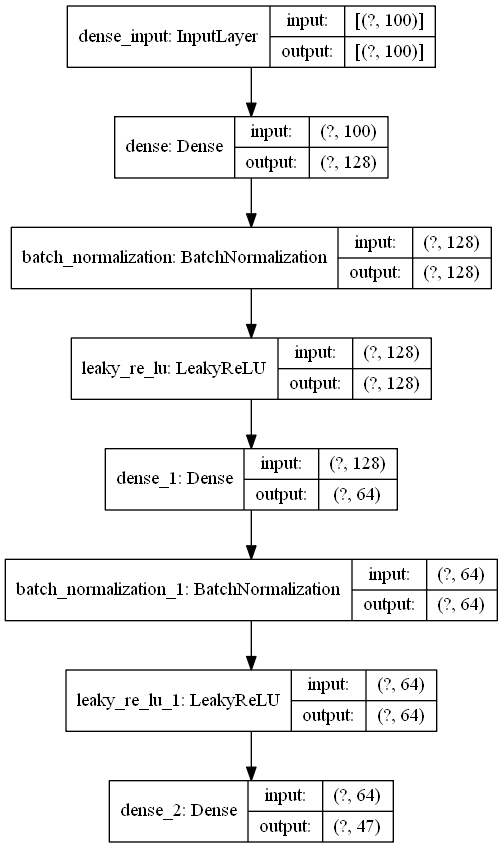

In [21]:
keras.utils.plot_model(YtoX_generator, to_file= "Generator.png", show_shapes=True)

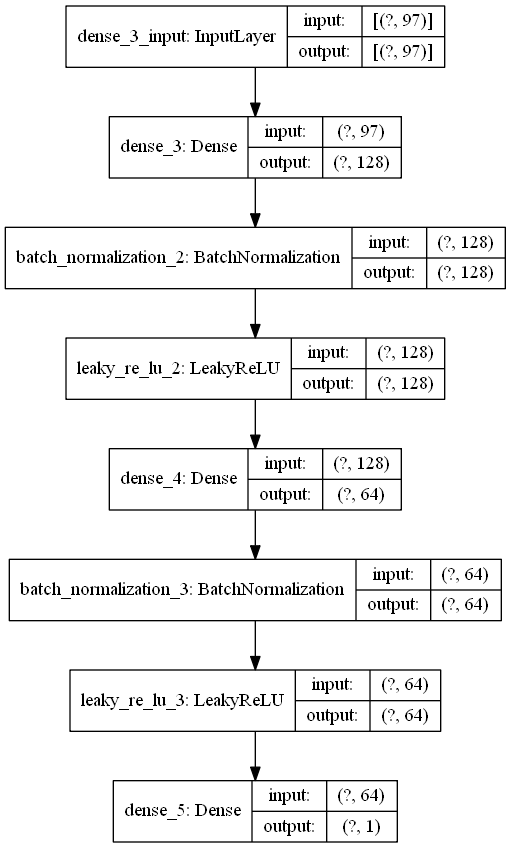

In [22]:
keras.utils.plot_model(YtoX_discriminator, to_file= "Discriminator.png", show_shapes=True)

In [21]:
YtoX_history = train(YtoX_generator, YtoX_discriminator, YtoX_dataset, N_EPOCH, YtoX_noise_dim)

Disc loss: 1.529821228981018, Gen loss: 0.5268574237823487. Time for epoch 0 is 0.47052669525146484 sec
Disc loss: 1.399017882347107, Gen loss: 0.6652337908744812. Time for epoch 10 is 2.3015835285186768 sec
Disc loss: 1.3762348651885987, Gen loss: 0.6628325462341309. Time for epoch 20 is 2.1785247325897217 sec
Disc loss: 1.3914401292800904, Gen loss: 0.6660652756690979. Time for epoch 30 is 2.1359989643096924 sec
Disc loss: 1.3641398668289184, Gen loss: 0.6654385685920715. Time for epoch 40 is 2.2719991207122803 sec
Disc loss: 1.4047901153564453, Gen loss: 0.6290238857269287. Time for epoch 50 is 2.264199733734131 sec
Disc loss: 1.385755753517151, Gen loss: 0.6447297811508179. Time for epoch 60 is 2.235928535461426 sec
Disc loss: 1.3632261753082275, Gen loss: 0.6587870836257934. Time for epoch 70 is 2.1579973697662354 sec
Disc loss: 1.3000951766967774, Gen loss: 0.735299801826477. Time for epoch 80 is 2.1510021686553955 sec
Disc loss: 1.3325653314590453, Gen loss: 0.7226122140884399. 

## GAN X &rarr; Y

In [22]:
XtoY_generator = make_generator_model(XtoY_noise_dim, X.shape[1], Y.shape[1])
XtoY_discriminator = make_discriminator_model(Y.shape[1], X.shape[1])

In [23]:
XtoY_history = train(XtoY_generator, XtoY_discriminator, XtoY_dataset, N_EPOCH, XtoY_noise_dim)

Disc loss: 1.565898847579956, Gen loss: 0.6384146690368653. Time for epoch 0 is 0.20999622344970703 sec
Disc loss: 1.2311942338943482, Gen loss: 0.843054449558258. Time for epoch 10 is 2.2004222869873047 sec
Disc loss: 1.6192099094390868, Gen loss: 0.5952154278755188. Time for epoch 20 is 2.172001838684082 sec
Disc loss: 1.4345619440078736, Gen loss: 0.7344567179679871. Time for epoch 30 is 2.2487709522247314 sec
Disc loss: 1.4046502828598022, Gen loss: 0.6839944124221802. Time for epoch 40 is 2.2524547576904297 sec
Disc loss: 1.4379597902297974, Gen loss: 0.6999018907546997. Time for epoch 50 is 2.2239279747009277 sec
Disc loss: 1.354801607131958, Gen loss: 0.7509806156158447. Time for epoch 60 is 2.1619226932525635 sec
Disc loss: 1.1933106899261474, Gen loss: 0.8936574459075928. Time for epoch 70 is 2.1790359020233154 sec
Disc loss: 1.1646817922592163, Gen loss: 0.8712470173835755. Time for epoch 80 is 2.251267433166504 sec
Disc loss: 1.2485716104507447, Gen loss: 0.8588082551956177.

# C2ST

In [24]:
TRAIN_TEST_PROP = 0.7

Y_real = Y
X_real = X

real_dataset = np.concatenate((X_real, Y_real), axis = 1).astype("float32")
real_labels = np.ones((real_dataset.shape[0],1), dtype = "float32")

In [25]:
X_real.shape

(268, 47)

In [26]:
def generate_examples(generator, num_imgs, noise_dim, condition):
    noise = tf.random.normal([num_imgs, noise_dim], dtype= "float32")
    labels = tf.convert_to_tensor(condition, dtype= "float32")
    inp = tf.concat([noise, labels], axis = 1)
    generated_image = generator(inp, training=False)
    return generated_image.numpy()

## C2ST Y &rarr; X

In [27]:
n_images = Y_real.shape[0]

X_fake = generate_examples(YtoX_generator, n_images, YtoX_noise_dim, Y_real)
YtoX_fake_labels = np.zeros((n_images,1), dtype= "float32")

In [28]:
YtoX_total_dataset = np.concatenate((X_real, X_fake), axis = 0)
YtoX_total_labels = np.concatenate((real_labels, YtoX_fake_labels), axis = 0)

In [29]:
n = YtoX_total_dataset.shape[0]

random_range = np.random.permutation(n)

train_indexes = random_range[:int(TRAIN_TEST_PROP * n)]
n_train = train_indexes.shape[0]
test_indexes = random_range[int(TRAIN_TEST_PROP * n):]
n_test = test_indexes.shape[0]

X_train_YtoX = YtoX_total_dataset[train_indexes, :]
Y_train_YtoX = YtoX_total_labels[train_indexes, :].reshape(-1)

X_test_YtoX = YtoX_total_dataset[test_indexes, :]
Y_test_YtoX = YtoX_total_labels[test_indexes, :].reshape(-1)

In [37]:
classifier_YtoX = KNeighborsClassifier(n_neighbors=int(math.sqrt(n_train)))
# Entrenamos con los datos de entrenamiento
classifier_YtoX.fit(X_train_YtoX, Y_train_YtoX)
# Evaluamos con los de test
acc_y_x = accuracy_score(Y_test_YtoX, classifier_YtoX.predict(X_test_YtoX))
acc_y_x

0.6086956521739131

## C2ST X &rarr; Y

In [32]:
n_images = X_real.shape[0]

Y_fake = generate_examples(XtoY_generator, n_images, XtoY_noise_dim, X_real)

XtoY_fake_labels = np.zeros((n_images,1), dtype= "float32")

In [33]:
XtoY_total_dataset = np.concatenate((Y_real, Y_fake), axis = 0)
XtoY_total_labels = np.concatenate((real_labels, XtoY_fake_labels), axis = 0)

In [34]:
n = XtoY_total_dataset.shape[0]
random_range = np.random.permutation(n)

train_indexes = random_range[:int(TRAIN_TEST_PROP * n)]
n_train = train_indexes.shape[0]
test_indexes = random_range[int(TRAIN_TEST_PROP * n):]
n_test = test_indexes.shape[0]

X_train_XtoY = XtoY_total_dataset[train_indexes, :]
Y_train_XtoY = XtoY_total_labels[train_indexes, :].reshape(-1)

X_test_XtoY = XtoY_total_dataset[test_indexes, :]
Y_test_XtoY = XtoY_total_labels[test_indexes, :].reshape(-1)

In [38]:
classifier_XtoY = KNeighborsClassifier(n_neighbors=int(math.sqrt(n_train)))
# Entrenamos con los datos de entrenamiento
classifier_XtoY.fit(X_train_XtoY, Y_train_XtoY)
# Evaluamos con los de test
acc_x_y = accuracy_score(Y_test_XtoY, classifier_XtoY.predict(X_test_XtoY))
acc_x_y

0.577639751552795

# Contraste de hipotesis

In [49]:
def correct_preds(true_labels, preds):
    correct_labels = []
    for i, true_label in enumerate(true_labels):
        correct_labels.append(int(preds[i]) == int(true_label))
    return np.array(correct_labels, dtype="float32")

In [50]:
correct_preds_x_y = correct_preds(Y_test_XtoY, classifier_XtoY.predict(X_test_XtoY))
correct_preds_y_x = correct_preds(Y_test_YtoX, classifier_YtoX.predict(X_test_YtoX))

In [53]:
sigma2 = (0.5 / n_test) - 2 * np.cov(correct_preds_x_y, correct_preds_y_x)[0,1]
sigma2

0.023214285714285708